# Google Earth Engine (GEE) DisALEXI 
## Mexico 2015 - Landsat Collection 1 TOA

Example of calling the GEE DisALEXI function for a singleLandsat 8 Collection 1 top-of-atmosphere reflectance image.  
Study area WRS2 tiles: p039r037, p038r037, p039r038, p038r038

https://console.cloud.google.com/storage/browser/gcp-public-data-landsat/LC08/01/038/038/LC08_L1TP_038038_20150717_20170226_01_T1/

In [1]:
import ee
from IPython.display import Image

# For some reason the initialize has to be before the model imports below
ee.Initialize()

import openet.disalexi.disalexi as disalexi
import openet.disalexi.landsat as landsat
import openet.disalexi.utils as utils

ndvi_palette = ['#EFE7E1', '#003300']
ssebop_et_palette = [
  'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
  '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']

### Study area

In [2]:
output_extent = [624000, 3535000, 714000, 3625000]
output_crs = 'EPSG:32611'
cell_size = 30
output_transform = [cell_size, 0, output_extent[0], 0, -cell_size, output_extent[3]]
output_transform_str = '[' + ','.join(map(str, output_transform)) + ']'
output_shape_str = '{0}x{1}'.format(
    int(abs(output_extent[2] - output_extent[0]) / cell_size),
    int(abs(output_extent[3] - output_extent[1]) / cell_size))
output_region = ee.Geometry.Rectangle(output_extent, output_crs, False) \
    .bounds(1, 'EPSG:4326').coordinates().getInfo()
print(output_transform_str)
print(output_shape_str)

[30,0,624000,0,-30,3625000]
3000x3000


In [3]:
thumbnail_region = [[-115.09, 32.32], [-115.09, 32.40], [-114.95, 32.40], [-114.95, 32.32]]
thumbnail_geom = ee.Geometry.Polygon(thumbnail_region)

### Prep DisALEXI Input

In [4]:
scene_id = 'LC08_038038_20150717'
landsat_img = ee.Image('LANDSAT/LC08/C01/T1_RT_TOA/LC08_038038_20150717')
image_crs = landsat_img.select('B2').projection().crs().getInfo()
image_transform = landsat_img.select('B2').projection().getInfo()['transform']
image_geom = landsat_img.select('B2').geometry()
# print(image_crs)
# print(image_transform)

input_img = ee.Image(landsat.Landsat(landsat_img).prep())

### NDVI

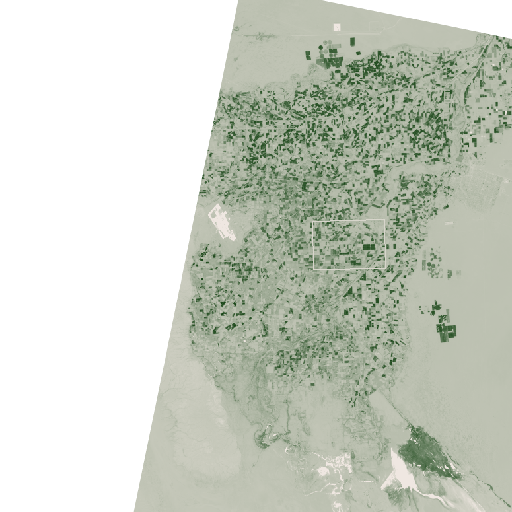

In [ ]:
Image(url=input_img.select(['ndvi']).paint(thumbnail_geom, 'red', 1).getThumbURL({
        'region': output_region, 'min': -0.1, 'max': 0.9, 
        'palette': ','.join(ndvi_palette)}), 
      embed=True, format='png')

### Apply DisALEXI

In [ ]:
# Use the CONUS ALEXI ET but the global landcover and elevation products
disalexi = disalexi.Image(
    input_img, 
    iterations=10,
    elevation=ee.Image('USGS/SRTMGL1_003').rename(['elevation']),
    landcover=ee.Image(
        ee.ImageCollection('users/cgmorton/GlobeLand30').mosaic()) \
            .divide(10).floor().multiply(10).rename(['landcover']),
    lc_type='GLOBELAND30')

ta_img = disalexi.compute_ta() \
    .reproject(crs=output_crs, crsTransform=output_transform)
ta_coarse_img = disalexi.aggregate(ta_img)
# Eventually make smoothing to a DisALEXI method
ta_smooth_img = ta_coarse_img \
    .resample('bilinear') \
    .reproject(crs=output_crs, crsTransform=output_transform)
et_img = disalexi.compute_et(ta_smooth_img)

# et_img = disalexi.compute_et(ta_smooth_img) \
#     .reproject(crs=output_crs, crsTransform=output_transform)

In [ ]:
print(ta_img.getInfo())
print(ta_coarse_img.getInfo())
print(ta_smooth_img.getInfo())
print(et_img.getInfo())

{'type': 'Image', 'bands': [{'id': 't_air', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:32611', 'crs_transform': [30.0, 0.0, 624000.0, 0.0, -30.0, 3625000.0]}]}
{'type': 'Image', 'bands': [{'id': 't_air', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [0.04, 0.0, -125.04, 0.0, -0.04, 49.82]}]}
{'type': 'Image', 'bands': [{'id': 't_air', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:32611', 'crs_transform': [30.0, 0.0, 624000.0, 0.0, -30.0, 3625000.0]}]}
{'type': 'Image', 'bands': [{'id': 'et', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': 0.01}, 'dimensions': [5, 6], 'origin': [103, 114], 'crs': 'EPSG:4326', 'crs_transform': [0.625, 0.0, -180.3125, 0.0, -0.5, 90.25]}]}


### Export to Drive

In [ ]:
et_task = ee.batch.Export.image.toDrive(
    et_img.toFloat(),
    description=scene_id + '_et',
    folder='DisALEXI',
    fileNamePrefix=scene_id + '_et',
    dimensions=output_shape_str,
    crs=output_crs,
    crsTransform=output_transform_str,
    maxPixels=1E10)

In [ ]:
# et_task.start()
# print('Status: {}'.format(et_task.status()))

In [ ]:
# ta_task = ee.batch.Export.image.toDrive(
#     ta_img.toFloat(),
#     description=scene_id + '_ta',
#     folder='DisALEXI',
#     fileNamePrefix=scene_id + '_ta',
#     dimensions=output_shape_str,
#     crs=output_crs,
#     crsTransform=output_transform_str,
#     maxPixels=1E10)

In [ ]:
# ta_coarse_task = ee.batch.Export.image.toDrive(
#     ta_coarse_img.toFloat(),
#     description=scene_id + '_ta_coarse',
#     folder='DisALEXI',
#     fileNamePrefix=scene_id + '_ta_coarse',
#     dimensions=output_shape_str,
#     crs=output_crs,
#     crsTransform=output_transform_str,
#     maxPixels=1E10)

In [ ]:
# ta_smooth_task = ee.batch.Export.image.toDrive(
#     ta_smooth_img.toFloat(),
#     description=scene_id + '_ta_smooth',
#     folder='DisALEXI',
#     fileNamePrefix=scene_id + '_ta_smooth',
#     dimensions=output_shape_str,
#     crs=output_crs,
#     crsTransform=output_transform_str,
#     maxPixels=1E10)

In [ ]:
# ta_task.start()
# print('Status: {}'.format(ta_task.status()))
# ta_coarse_task.start()
# print('Status: {}'.format(ta_coarse_task.status()))
# ta_smooth_task.start()
# print('Status: {}'.format(ta_smooth_task.status()))

### Thumbnails

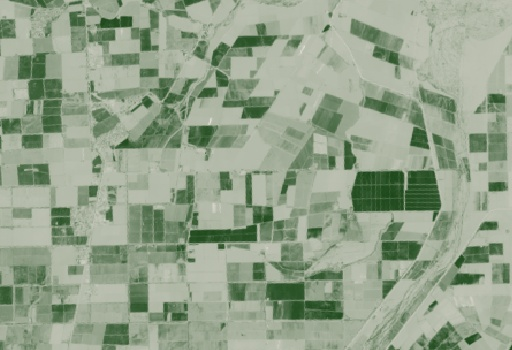

In [ ]:
Image(url=input_img.select(['ndvi']).getThumbURL({
        'region': thumbnail_region, 'min': -0.1, 'max': 0.9, 
        'palette': ','.join(ndvi_palette)}), 
      embed=True, format='png')

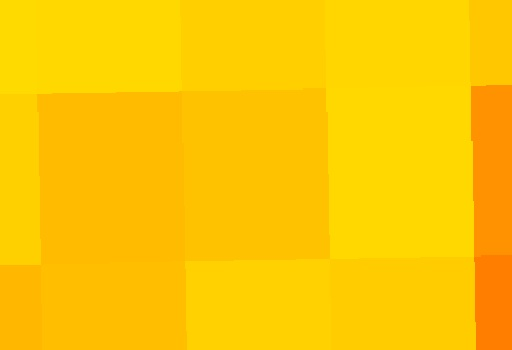

In [ ]:
alexi_url = ee.Image(disalexi.alexi_et).reproject(crs=output_crs, crsTransform=output_transform).getThumbURL({
    'region': thumbnail_region, 'min': 0, 'max': 10, 
    'palette': ','.join(['FF0000', 'FFFF00', '00FFFF', '0000FF'])})
# print(alexi_url)
Image(url=alexi_url, embed=True, format='png')

In [ ]:
ta_url = ta_img.getThumbURL({
    'region': thumbnail_region, 'min': 273, 'max': 325, 
    'palette': ','.join(['FF0000', 'FFFF00', '00FFFF', '0000FF'])})
print(ta_url)
Image(url=ta_url, embed=True, format='png')

https://earthengine.googleapis.com/api/thumb?thumbid=50c8dab57b105fd7a6071ebde4676ee3&token=0f836c2742168aef1248091b5d648f46


In [ ]:
# ta_coarse_url = ta_coarse_img.getThumbURL({
#     'region': thumbnail_region, 'min': 273, 'max': 325, 
#     'palette': ','.join(['FF0000', 'FFFF00', '00FFFF', '0000FF'])})
# # print(ta_coarse_url)
# Image(url=ta_coarse_url, embed=True, format='png')

In [ ]:
# ta_smooth_url = ta_smooth_img.getThumbURL({
#     'region': thumbnail_region, 'min': 273, 'max': 325, 
#     'palette': ','.join(['FF0000', 'FFFF00', '00FFFF', '0000FF'])})
# # print(ta_smooth_url)
# Image(url=ta_smooth_url, embed=True, format='png')

In [ ]:
# et_url = et_img.getThumbURL({
#     'region': thumbnail_region, 'min': 0, 'max': 10, 
#     'palette': ','.join(ssebop_et_palette)})
# # print(et_url)
# Image(url=et_url, embed=True, format='png')